In [ ]:
# https://journals.plos.org/ploscompbiol/article?id=10.1371%2Fjournal.pcbi.1011890&utm_source
# https://openreview.net/forum?id=FDsWd0NOB5&utm_source



# Preprocessing & feature checklist (ready to paste into your pipeline README)

**Color / channels**

* Split channels; compute **R/(R+G)** map to emphasize nuclei over tissue.
* **Flat-field** (shading) correction per frame; then **per-patch z-score** or percentile normalization for R and G. ([confocal.uconn.edu][5])

**Background & neighbors**

* Detect and optionally **mask green “ring/arc” structures** (large-scale band-pass or morphological opening on G).
* Use a **local non-maximum suppression (NMS)** around the annotated centroid to **down-weight neighbor nuclei** entering the crop (seen as bright red speckles at edges).

**Denoising / contrast**

* Gentle **Gaussian/median** filter on R (avoid over-smoothing small chromatin details).
* Optional **CLAHE on R channel only** to boost weak telophase contrast (clip limit low).

**Shape & phase descriptors (per patch)**

* **Centroidal intensity profile**: radial profile of R to flag compact centers (metaphase) vs bimodal profiles (anaphase/telophase).
* **Bimodality test** in R (fit **two 2D Gaussians** or run **DoG-based lobe finder**):

  * 1 peak → consistent with **metaphase**;
  * 2 peaks with increasing **peak-to-peak distance** → **anaphase**;
  * 2 peaks with **falling peak intensity / increasing spread** → **telophase**. (Use a separation threshold relative to estimated nuclear diameter.)
* **Eccentricity/orientation**: principal-axis of R—anaphase tends to be **more elongated** along the spindle axis; metaphase more **isotropic**.
* **Peak-to-background SNR** in R and **R/(R+G)**: lower in telophase; moderate in anaphase; higher in clear metaphase cores.
* **Neighbor leakage score**: count of **red high-intensity pixels near patch borders**; use as a quality covariate during training/augmentation.

**Augmentation guardrails (especially if you balance with diffusion)**

* Keep **mean-projection softness** (don’t synthesize hard max-projection edges).
* Respect **phase morphology**:

  * Metaphase → **single compact** nuclear mass;
  * Anaphase → **two masses**, widening gap;
  * Telophase → **two fading blobs**, overall red intensity dropping.
* Randomize presence of **green ring artifacts** but **never bind them** to a phase label (avoid spurious correlations).

---

## TL;DR — image features to “understand the image itself”

* **Signal:** red=nucleus (target), green=tissue/background; **mean projection** makes boundaries soft. ([arXiv][1])
* **Artifacts:** **green arcs/rings** from rosette curvature and projection; **red speckles at edges** from neighbor nuclei. ([arXiv][6])
* **Phase morphology to preserve:** compact **metaphase** core → **two masses** in **anaphase** → **two fading blobs** in **telophase**. ([micro.magnet.fsu.edu][2])

If you want, I can generate a quick panel for these exact patches showing **R, G, R/(R+G)**, plus a **2-peak fit** overlay to visualize “metaphase vs anaphase vs telophase” cues before you plug them into your augmentation/balancing step.

[1]: https://arxiv.org/abs/2406.19556?utm_source=chatgpt.com "BOrg: A Brain Organoid-Based Mitosis Dataset for Automatic Analysis of Brain Diseases"
[2]: https://micro.magnet.fsu.edu/cells/fluorescencemitosis/metaphasesmall.html?utm_source=chatgpt.com "Mitosis with Fluorescence Microscopy - Metaphase"
[3]: https://pmc.ncbi.nlm.nih.gov/articles/PMC4435798/?utm_source=chatgpt.com "Live Cell Fluorescence Imaging for Phenotypic Analysis of ..."
[4]: https://www.sciencedirect.com/topics/neuroscience/telophase?utm_source=chatgpt.com "Telophase - an overview | ScienceDirect Topics"
[5]: https://confocal.uconn.edu/wp-content/uploads/sites/1081/2016/02/2014-05_Analyzing_fluorescence_microscopy_images.pdf?utm_source=chatgpt.com "Analyzing fluorescence microscopy images with ImageJ"
[6]: https://arxiv.org/html/2406.19556v1?utm_source=chatgpt.com "BOrg: A Brain Organoid-Based Mitosis Dataset for ..."


## Preproces 

In [2]:
# Cell 1 — Config & root discovery
import os, json, random, glob
from pathlib import Path
from typing import Dict
from PIL import Image, ImageOps, ImageFilter

# --- Choose projection folder to use ---
PROJECTION = "max_projection"   # change to "max_projection" if you prefer

MIP_MODE = (PROJECTION.lower() == "max_projection")
print("Projection mode:", "MAX (MIP)" if MIP_MODE else "MEAN")


project_path = "."
repo_path = os.path.join(project_path, "borg-main")
data_root_dir = os.path.join(repo_path, f"data/{PROJECTION}")
train_json_path = os.path.join(data_root_dir, "organoid_coco_train.json")
val_json_path   = os.path.join(data_root_dir, "organoid_coco_val.json")
train_images_dir = os.path.join(data_root_dir, "images", "train")
val_images_dir   = os.path.join(data_root_dir, "images", "val")

# Output dirs
PATCH_CACHE_TRAIN = "patch_cache_train"   # new cache for cropped patches (train only)
MASKS_DIR         = "processed_masks_train"
SYNTH_DIR         = "synthetic_patches"
ARTIFACTS         = "artifacts"

IMG_SIZE = 96
CLASSES = ["Prophase","Metaphase","Anaphase","Telophase"]

for p in [PATCH_CACHE_TRAIN, MASKS_DIR, SYNTH_DIR, ARTIFACTS]:
    Path(p).mkdir(parents=True, exist_ok=True)

print("Using projection:", PROJECTION)
print("Repo path:", os.path.abspath(repo_path))
print("Data root:", os.path.abspath(data_root_dir))
print("Train images:", os.path.abspath(train_images_dir))
print("Val images:", os.path.abspath(val_images_dir))

Projection mode: MAX (MIP)
Using projection: max_projection
Repo path: /home/sebas_dev_linux/projects/snn_project/Diffusion_SNN_ML_v0/borg-main
Data root: /home/sebas_dev_linux/projects/snn_project/Diffusion_SNN_ML_v0/borg-main/data/max_projection
Train images: /home/sebas_dev_linux/projects/snn_project/Diffusion_SNN_ML_v0/borg-main/data/max_projection/images/train
Val images: /home/sebas_dev_linux/projects/snn_project/Diffusion_SNN_ML_v0/borg-main/data/max_projection/images/val


In [3]:
# Cell 2 — Load train/val annotations (COCO JSON)
with open(train_json_path, "r") as f:
    train_coco = json.load(f)
with open(val_json_path, "r") as f:
    val_coco = json.load(f)

categories_map: Dict[int, str] = {c["id"]: c["name"] for c in train_coco["categories"]}
train_id_to_filename = {img["id"]: img["file_name"] for img in train_coco["images"]}
val_id_to_filename   = {img["id"]: img["file_name"] for img in val_coco["images"]}

train_annotations = train_coco["annotations"]   # we will synthesize from these only
val_annotations   = val_coco["annotations"]

print("Classes:", categories_map)
print("Train annotations:", len(train_annotations))
print("Val annotations:", len(val_annotations))

Classes: {1: 'Prophase', 2: 'Metaphase', 3: 'Anaphase', 4: 'Telophase'}
Train annotations: 556
Val annotations: 181


In [4]:
# Cell 3 — Cache train patches directly from COCO bboxes (robust path resolution)
from collections import defaultdict
from pathlib import Path
from PIL import Image

# Ensure cache dirs exist
for cls in CLASSES:
    Path(PATCH_CACHE_TRAIN, cls).mkdir(parents=True, exist_ok=True)

def resolve_image_path(file_name: str) -> Path | None:
    """Resolve image path regardless of whether file_name already contains images/train/…"""
    p = Path(file_name)
    cands = []
    if p.is_absolute():
        cands.append(p)
    # Typical COCO: file_name already 'images/train/xxx.png' relative to the projection root
    cands.append(Path(data_root_dir) / file_name)
    # Fallbacks: try train-images dir and basename-only
    cands.append(Path(train_images_dir) / file_name)
    cands.append(Path(train_images_dir) / p.name)
    for c in cands:
        if c.exists():
            return c
    return None

def _si(v):  # safe int
    try:
        return int(round(float(v)))
    except Exception:
        return int(v)

PAD_FRAC = 0.10  # small padding around bbox
ann_to_patch = {}
class_to_train_ann_ids = defaultdict(list)
missing_imgs, skipped_bad_bbox = 0, 0

for ann in train_annotations:
    cls = categories_map[ann["category_id"]]
    img_id = ann["image_id"]
    # Look up file_name via the IMAGES table
    file_name = train_id_to_filename.get(img_id)
    if file_name is None:
        missing_imgs += 1
        continue
    img_path = resolve_image_path(file_name)
    if img_path is None:
        missing_imgs += 1
        continue

    img = Image.open(img_path).convert("RGB")
    W, H = img.width, img.height

    # COCO bbox: [x, y, width, height] (xywh, pixels)
    bb = ann.get("bbox")
    if not bb or len(bb) != 4:
        skipped_bad_bbox += 1
        continue
    x, y, bw, bh = float(bb[0]), float(bb[1]), float(bb[2]), float(bb[3])
    if bw <= 1 or bh <= 1:
        skipped_bad_bbox += 1
        continue

    # pad and clamp to image bounds
    x0 = max(0, _si(x - PAD_FRAC * bw))
    y0 = max(0, _si(y - PAD_FRAC * bh))
    x1 = min(W, _si(x + bw + PAD_FRAC * bw))
    y1 = min(H, _si(y + bh + PAD_FRAC * bh))
    if x1 <= x0 or y1 <= y0:
        skipped_bad_bbox += 1
        continue

    patch = img.crop((x0, y0, x1, y1)).resize((IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS)
    outp = Path(PATCH_CACHE_TRAIN) / cls / f"patch_{ann['id']}.png"
    patch.save(outp)
    ann_to_patch[ann["id"]] = str(outp)
    class_to_train_ann_ids[cls].append(ann["id"])

print("Cached train patches:", len(ann_to_patch))
print("Per-class cached:", {c: len(v) for c, v in class_to_train_ann_ids.items()})
print("Missing source images:", missing_imgs, "| Skipped (bad/degenerate bbox):", skipped_bad_bbox)

# Optional quick sanity check: print a couple of resolved examples
some = next(iter(train_annotations), None)
if some:
    fn = train_id_to_filename.get(some["image_id"])
    print("Example file_name from JSON:", fn)
    print("Resolved path:", resolve_image_path(fn))


Cached train patches: 556
Per-class cached: {'Prophase': 282, 'Metaphase': 146, 'Anaphase': 69, 'Telophase': 59}
Missing source images: 0 | Skipped (bad/degenerate bbox): 0
Example file_name from JSON: images/train/phase_1_new_v10_frame_02.png
Resolved path: borg-main/data/max_projection/images/train/phase_1_new_v10_frame_02.png


In [5]:
# --- Cell 3A: helpers (add before the cache step) ---
import numpy as np
from typing import Tuple, Optional, Dict
from PIL import Image
from skimage.morphology import white_tophat, opening, disk
from skimage.exposure import rescale_intensity
from math import ceil




DEBUG_EVERY = 150   # print a verbose line every N patches

def _log(msg: str):
    print(f"[preproc] {msg}")
    
def percentile_clip_u8(arr_u8: np.ndarray, p: float = 99.5) -> np.ndarray:
    """Clip bright outliers (MIP often has a few saturated pixels), rescale to 0–255."""
    hi = np.percentile(arr_u8, p)
    arr = np.clip(arr_u8.astype(np.float32), 0, hi) / (hi + 1e-6)
    return (arr * 255.0).astype(np.uint8)

def apply_mip_preclip_and_despeckle(img_rgb: Image.Image) -> Image.Image:
    """
    For MIP: (1) percentile clip per-channel; (2) tiny opening to remove single-pixel speckles.
    """
    arr = np.asarray(img_rgb).astype(np.uint8)
    # per-channel clip
    for c in range(3):
        arr[..., c] = percentile_clip_u8(arr[..., c], p=99.5)
        # tiny despeckle on the *index* happens later, but a 1px opening here reduces hot pixels in RGB too
        arr[..., c] = opening(arr[..., c], disk(1))
    return Image.fromarray(arr, mode="RGB")    

def letterbox(im: Image.Image, size: int, bg_val: Tuple[int,int,int]=(0,0,0)) -> Tuple[Image.Image, float, float, int, int]:
    """Resize preserving aspect ratio and pad to (size,size). Returns (img, sx, sy, pad_x, pad_y)."""
    w, h = im.size
    scale = min(size / w, size / h)
    nw, nh = int(round(w * scale)), int(round(h * scale))
    im_res = im.resize((nw, nh), Image.Resampling.LANCZOS)
    canvas = Image.new("RGB", (size, size), bg_val)
    pad_x = (size - nw) // 2
    pad_y = (size - nh) // 2
    canvas.paste(im_res, (pad_x, pad_y))
    sx, sy = nw / w, nh / h
    return canvas, sx, sy, pad_x, pad_y

def rolling_shading_correction_rgb(im: Image.Image, rad_px:int=21) -> Image.Image:
    """
    Fast per-channel 'rolling-ball-like' flat-field using white tophat (opening subtraction).
    Use larger radius on full frames; smaller on 96x96 patches. Ref: morphology tophat. 
    """
    arr = np.asarray(im).astype(np.uint8)
    se = disk(rad_px)
    out = np.empty_like(arr)
    for c in range(3):
        out[..., c] = white_tophat(arr[..., c], footprint=se)
        # stretch to full dynamic range to stabilize thresholds
        out[..., c] = rescale_intensity(out[..., c], in_range='image', out_range=(0,255)).astype(np.uint8)
    return Image.fromarray(out, mode="RGB")

def suppress_green_ring(im: Image.Image, ring_rad:int=11) -> Image.Image:
    """
    Remove large-scale green arcs (rosette/apical ring) so they don't leak into R/(R+G).
    """
    arr = np.asarray(im).astype(np.uint8)
    G = arr[...,1]
    G_bg = opening(G, disk(ring_rad))
    G_supp = np.clip(G.astype(np.int16) - G_bg.astype(np.int16), 0, 255).astype(np.uint8)
    arr[...,1] = G_supp
    return Image.fromarray(arr, 'RGB')

def linear_unmix_rg(arr: np.ndarray, alpha: float=0.0, beta: float=0.0) -> np.ndarray:
    """
    Optional: simple 2x2 linear unmixing for RG channels:
      R' = R - alpha*G
      G' = G - beta*R
    Provide alpha/beta if you measure bleedthrough; defaults 0 (no change).
    """
    arr = arr.astype(np.float32)
    R = arr[...,0] - alpha * arr[...,1]
    G = arr[...,1] - beta  * arr[...,0]
    B = arr[...,2]
    arr2 = np.stack([np.clip(R,0,255), np.clip(G,0,255), np.clip(B,0,255)], axis=-1).astype(np.uint8)
    return arr2


In [6]:
# --- Cell 3B: cache train patches with flat-field + ring suppression + letterbox ---
from collections import defaultdict
from pathlib import Path

for cls in CLASSES:
    Path(PATCH_CACHE_TRAIN, cls).mkdir(parents=True, exist_ok=True)

PAD_FRAC_CLASS = {
    "Prophase": 0.25,
    "Metaphase": 0.25,
    "Anaphase": 0.35,   # two lobes spread
    "Telophase": 0.35,  # two softer, wider blobs
}


ann_to_patch = {}
class_to_train_ann_ids = defaultdict(list)
missing_imgs, skipped_bad_bbox = 0, 0

for i, ann in enumerate(train_annotations, 1):
    cls = categories_map[ann["category_id"]]
    img_id = ann["image_id"]
    file_name = train_id_to_filename.get(img_id)
    if file_name is None:
        missing_imgs += 1
        continue

    img_path = resolve_image_path(file_name)
    if img_path is None:
        missing_imgs += 1
        continue

    # -- load & full-frame flat-field --
    img_raw = Image.open(img_path).convert("RGB")
    img_corr = rolling_shading_correction_rgb(img_raw, rad_px=27)  # larger radius on full frames
    img_corr = suppress_green_ring(img_corr, ring_rad=13)

    W, H = img_corr.size
    bb = ann.get("bbox")
    if not bb or len(bb) != 4:
        skipped_bad_bbox += 1
        continue
    x, y, bw, bh = map(float, bb)
    if bw <= 1 or bh <= 1:
        skipped_bad_bbox += 1
        continue

    # pad bbox and crop
    pad = PAD_FRAC_CLASS.get(cls, 0.30)
    x0 = max(0, int(round(x - pad * bw)))
    y0 = max(0, int(round(y - pad * bh)))
    x1 = min(W, int(round(x + bw + pad * bw)))
    y1 = min(H, int(round(y + bh + pad * bh)))
    if x1 <= x0 or y1 <= y0:
        skipped_bad_bbox += 1
        continue

    crop = img_corr.crop((x0, y0, x1, y1))
    patch, sx, sy, pad_x, pad_y = letterbox(crop, IMG_SIZE, bg_val=(0,0,0))
    
    # === NEW: MIP guards on the letterboxed patch ===
    if MIP_MODE:
        patch = apply_mip_preclip_and_despeckle(patch)

    outp = Path(PATCH_CACHE_TRAIN) / cls / f"patch_{ann['id']}.png"
    patch.save(outp)

    outp = Path(PATCH_CACHE_TRAIN) / cls / f"patch_{ann['id']}.png"
    patch.save(outp)
    ann_to_patch[ann["id"]] = str(outp)
    class_to_train_ann_ids[cls].append(ann["id"])

    if i % DEBUG_EVERY == 0:
        _log(f"Cached {i} patches... last class={cls}, img_id={img_id}, bbox=({int(x)},{int(y)},{int(bw)}x{int(bh)})")

print("[cache] Cached train patches:", len(ann_to_patch))
print("[cache] Per-class:", {c: len(v) for c, v in class_to_train_ann_ids.items()})
print("[cache] Missing images:", missing_imgs, "| Skipped bad bbox:", skipped_bad_bbox)


/tmp/ipykernel_9054/1783352443.py:60: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(out, mode="RGB")
/tmp/ipykernel_9054/1783352443.py:71: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr, 'RGB')
/tmp/ipykernel_9054/1783352443.py:33: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr, mode="RGB")


[preproc] Cached 150 patches... last class=Prophase, img_id=67, bbox=(205,94,50x50)
[preproc] Cached 300 patches... last class=Metaphase, img_id=119, bbox=(447,228,50x50)
[preproc] Cached 450 patches... last class=Prophase, img_id=184, bbox=(436,382,50x50)
[cache] Cached train patches: 556
[cache] Per-class: {'Prophase': 282, 'Metaphase': 146, 'Anaphase': 69, 'Telophase': 59}
[cache] Missing images: 0 | Skipped bad bbox: 0


In [ ]:
# --- Cell 4: robust nucleus via hysteresis on R/(R+G), ring-limited cytoplasm, watershed, QC ---
from typing import Tuple, Dict
import numpy as np
from pathlib import Path
from PIL import Image

from skimage.filters import threshold_otsu, threshold_local
from skimage.morphology import (
    remove_small_objects, remove_small_holes,
    binary_opening, binary_closing, white_tophat, disk,
    opening, binary_dilation, binary_erosion, reconstruction
)
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.segmentation import watershed
from skimage.measure import label as cc_label, regionprops
from scipy.ndimage import distance_transform_edt, gaussian_filter

# Fallbacks if not defined above
try:
    _ = DEBUG_EVERY
except NameError:
    DEBUG_EVERY = 250
try:
    _ = _log
except NameError:
    def _log(*a, **k): print(*a)
try:
    _ = MIP_MODE
except NameError:
    MIP_MODE = False  # default: mean-projection

MASKS_DIR = "processed_masks_train"
IMG_SIZE  = 96

# Illumination / morphology params
TOPHAT_RAD = 7           # a bit larger to reduce halo rings on mean/MIP
MIN_SIZE_NUC = 120
MIN_SIZE_CYT = 250
HOLE_SIZE    = 180
SE_RADIUS    = 3
BORDER_PX    = 4

# Hysteresis (double threshold) defaults on the ratio image
HI_PCT = 85     # seed threshold percentile
LO_PCT = 55     # grow threshold percentile
# If nucleus ends up too small, we automatically relax these by a few percent.

# Optional simple cross-talk compensation (R <- R - alpha*G) before ratio
CROSSTALK_ALPHA = 0.20   # set 0.0 to disable

Path(MASKS_DIR).mkdir(exist_ok=True)

def _binary_clean(bw, min_size, hole_size=HOLE_SIZE, se=SE_RADIUS):
    bw = remove_small_objects(bw, min_size=min_size)
    bw = remove_small_holes(bw, area_threshold=hole_size)
    selem = disk(se)
    bw = binary_opening(bw, selem)
    bw = binary_closing(bw, selem)
    return bw

def _otsu_or_local(channel_u8, block=17, offset=-2):
    """MEAN: Otsu -> fallback local.  MIP: Local -> fallback Otsu."""
    if not MIP_MODE:
        try:
            if channel_u8.std() < 1.0:
                raise ValueError("flat")
            t = threshold_otsu(channel_u8)
            return channel_u8 > t
        except Exception:
            return channel_u8 > threshold_local(channel_u8, block_size=block, offset=offset)
    else:
        try:
            bw = channel_u8 > threshold_local(channel_u8, block_size=block, offset=offset)
            if bw.mean() < 0.001 or bw.mean() > 0.999:
                raise ValueError("degenerate local")
            return bw
        except Exception:
            t = threshold_otsu(channel_u8)
            return channel_u8 > t

def _index_rg(Ru8: np.ndarray, Gu8: np.ndarray) -> np.ndarray:
    """R/(R+G) with top-hat; mild denoise+blur; tiny despeckle for MIP."""
    eps = 1e-6
    # simple cross-talk mitigation
    Rpre = np.clip(Ru8.astype(float) - CROSSTALK_ALPHA * Gu8.astype(float), 0, 255).astype(np.uint8)
    Rcorr = white_tophat(Rpre, footprint=disk(TOPHAT_RAD))
    Gcorr = white_tophat(Gu8, footprint=disk(TOPHAT_RAD))

    idx = Rcorr.astype(np.float32) / (Rcorr.astype(np.float32) + Gcorr.astype(np.float32) + eps)

    # NLM preserves texture; a tiny Gaussian helps connectivity
    sigma_est = float(np.mean(estimate_sigma(idx, channel_axis=None)))
    idx_dn = denoise_nl_means(idx, h=0.8*sigma_est if sigma_est > 0 else 0.02,
                              fast_mode=True, patch_size=5, patch_distance=7)
    idx_sm = gaussian_filter(idx_dn, sigma=0.8)   # soften small holes
    idx_u8 = (np.clip(idx_sm, 0, 1) * 255).astype(np.uint8)

    if MIP_MODE:
        idx_u8 = opening(idx_u8, disk(1))  # strip 1–2 px hot specks
    return idx_u8

def _hysteresis_bw(u8: np.ndarray, hi_pct=85, lo_pct=55):
    hi = np.percentile(u8, hi_pct)
    lo = np.percentile(u8, lo_pct)
    seed = (u8 >= hi).astype(np.uint8)
    mask = (u8 >= lo).astype(np.uint8)
    # 8-connected footprint prevents “blocky/square” islands
    fp = np.ones((3,3), dtype=bool)
    rec = reconstruction(seed.astype(float), mask.astype(float), method="dilation", footprint=fp)
    return rec > 0

def _watershed_keep_nearest(nuc_bw: np.ndarray, ann_bbox: Tuple[float,float,float,float]) -> np.ndarray:
    if nuc_bw.sum() == 0:
        return nuc_bw
    dist = distance_transform_edt(nuc_bw)
    vals = dist[nuc_bw]
    if vals.size == 0:
        return nuc_bw
    thr = np.percentile(vals, 80)
    markers = cc_label(dist > thr)
    if markers.max() == 0:
        return nuc_bw
    ws = watershed(-dist, markers, mask=nuc_bw)
    # keep component nearest bbox center
    x, y, w, h = ann_bbox
    cx, cy = x + w/2, y + h/2
    best_lab, best_d = 0, 1e12
    for lab_id in np.unique(ws)[1:]:
        ys, xs = np.where(ws == lab_id)
        if xs.size == 0:
            continue
        cxi, cyi = xs.mean(), ys.mean()
        d = (cxi - cx)**2 + (cyi - cy)**2
        if d < best_d:
            best_d, best_lab = d, lab_id
    return (ws == best_lab)

def _cyto_ring_from_nucleus(nuc_bw: np.ndarray, r_min: int = 4, r_max: int = 9) -> np.ndarray:
    if nuc_bw.sum() == 0:
        return np.zeros_like(nuc_bw, dtype=bool)
    # distance from EACH background pixel to nearest nucleus pixel
    dist = distance_transform_edt(~nuc_bw)
    ring = (dist >= r_min) & (dist <= r_max)
    return ring

def _qc_metrics(nuc_bw: np.ndarray, arr_rgb: np.ndarray) -> Dict[str, float]:
    H, W = nuc_bw.shape
    b = BORDER_PX
    border = np.zeros_like(nuc_bw, dtype=bool)
    border[:b,:] = border[-b:,:] = border[:,:b] = border[:,-b:] = True
    border_red_ratio = float(((nuc_bw & border).sum()) / (H*W + 1e-6))
    if nuc_bw.sum() == 0:
        return dict(border_red_ratio=border_red_ratio, snr=0.0,
                    eccentricity=0.0, peak_sep=0.0, area=0.0)
    R = arr_rgb[..., 0].astype(np.float32)
    bg = (~nuc_bw).astype(bool)
    snr = float(R[nuc_bw].mean() / (R[bg].std() + 1e-6)) if bg.any() else 0.0
    lab = cc_label(nuc_bw.astype(np.uint8))
    ecc = max((rp.eccentricity for rp in regionprops(lab)), default=0.0)
    dist = distance_transform_edt(nuc_bw)
    nuc_vals = dist[nuc_bw]
    peak_sep = 0.0
    if nuc_vals.size >= 2:
        thr = np.percentile(nuc_vals, 85)
        peaks = np.argwhere(dist > thr)
        if len(peaks) >= 2:
            p1, p2 = peaks[0], peaks[-1]
            peak_sep = float(np.linalg.norm(p1 - p2))
    area = float(nuc_bw.sum()) / (H * W)
    return dict(border_red_ratio=border_red_ratio, snr=snr,
                eccentricity=ecc, peak_sep=peak_sep, area=area)

def build_masks_from_patch_with_ws(png_path: str, ann_bbox_xywh: Tuple[float,float,float,float]):
    from skimage.measure import label, regionprops
    im = Image.open(png_path).convert("RGB")
    if MIP_MODE:
        # Safe double-clip + tiny despeckle if you already defined this; otherwise omit.
        try:
            im = apply_mip_preclip_and_despeckle(im)
        except NameError:
            pass

    arr = np.asarray(im).astype(np.uint8)
    R, G = arr[...,0], arr[...,1]

    # --- nucleus via R/(R+G) + hysteresis ---
    idx_u8 = _index_rg(R, G)
    nuc = _hysteresis_bw(idx_u8, HI_PCT, LO_PCT)
    nuc = _binary_clean(nuc, min_size=MIN_SIZE_NUC)
    nuc = remove_small_holes(nuc, area_threshold=120)
    nuc = binary_closing(nuc, disk(1))
    # auto-relax if still tiny
    if nuc.sum() < 80:  # ~0.9% of 96x96
        nuc = _hysteresis_bw(idx_u8, HI_PCT-5, LO_PCT-5)
        nuc = _binary_clean(nuc, min_size=MIN_SIZE_NUC)
    nuc = _watershed_keep_nearest(nuc, ann_bbox_xywh)

    # --- cytoplasm limited to peri-nuclear ring & connected to it ---
    Gcorr = white_tophat(G, footprint=disk(TOPHAT_RAD))
    cyt_raw = _otsu_or_local(Gcorr, block=17, offset=-1)
    cyt_raw = _binary_clean(cyt_raw, min_size=MIN_SIZE_CYT)

    ring = _cyto_ring_from_nucleus(nuc, r_min=4, r_max=9)   # narrower than before
    cyt = np.zeros_like(cyt_raw, dtype=bool)
    if ring.any() and cyt_raw.any():
        lab = label(cyt_raw, connectivity=2)
        # nucleus centroid for radial check
        nuc_lab = label(nuc)
        nuc_cy, nuc_cx = regionprops(nuc_lab)[0].centroid
        for rp in regionprops(lab):
            comp = (lab == rp.label)
            if not (comp & ring).any():
                continue
            # radial gate: centroid distance within ring band (+/- 1 px slack)
            dy = rp.centroid[0] - nuc_cy
            dx = rp.centroid[1] - nuc_cx
            r = np.hypot(dy, dx)
            if 3 <= r <= 10:           # tune with your scale; start narrow
                cyt |= comp
    # final tidy
    from skimage.morphology import binary_opening, disk, remove_small_objects
    cyt = binary_opening(cyt, disk(1))
    cyt = remove_small_objects(cyt, min_size=MIN_SIZE_CYT)

    # outputs
    union = (nuc | cyt).astype(np.uint8) * 255
    seg_rgb = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
    seg_rgb[...,0] = nuc.astype(np.uint8) * 255   # red=nucleus
    seg_rgb[...,1] = cyt.astype(np.uint8) * 255   # green=cyto (ring)

    qc = _qc_metrics(nuc.astype(bool), arr)
    return Image.fromarray(union, "L"), Image.fromarray(seg_rgb, "RGB"), qc

# ---- run for all cached patches ----
Path(MASKS_DIR).mkdir(exist_ok=True)
qc_rows = []
for cls, ann_ids in class_to_train_ann_ids.items():
    (Path(MASKS_DIR) / cls).mkdir(parents=True, exist_ok=True)
    _log(f"Processing class: {cls} ({len(ann_ids)} patches)")
    for j, ann_id in enumerate(ann_ids, 1):
        src = ann_to_patch[ann_id]
        bbox_xywh = (IMG_SIZE/4, IMG_SIZE/4, IMG_SIZE/2, IMG_SIZE/2)  # near center
        mL, mRGB, qc = build_masks_from_patch_with_ws(src, bbox_xywh)
        Image.fromarray(np.asarray(mL)).save(Path(MASKS_DIR) / cls / f"mask_{ann_id}.png")
        Image.fromarray(np.asarray(mRGB)).save(Path(MASKS_DIR) / cls / f"seg_{ann_id}.png")
        qc_rows.append((cls, ann_id, qc['area'], qc['snr'], qc['eccentricity'],
                        qc['peak_sep'], qc['border_red_ratio']))
        if (j % DEBUG_EVERY) == 0:
            cls_rows = [r for r in qc_rows if r[0] == cls]
            _log(f"{cls}: {j} masks | mean SNR={np.mean([r[3] for r in cls_rows]):.2f} | "
                 f"mean ecc={np.mean([r[4] for r in cls_rows]):.2f} | "
                 f"mean border-red={np.mean([r[6] for r in cls_rows]):.3f}")
print("[masks] 2-channel masks written (L & RGB).")


[preproc] Processing class: Prophase (282 patches)


/tmp/ipykernel_9054/1783352443.py:33: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr, mode="RGB")


UnboundLocalError: local variable 'disk' referenced before assignment

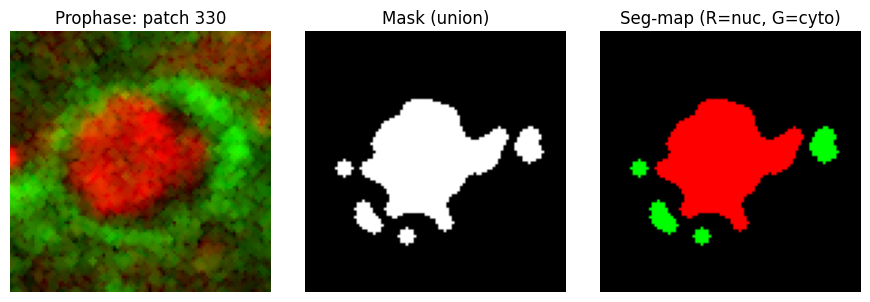

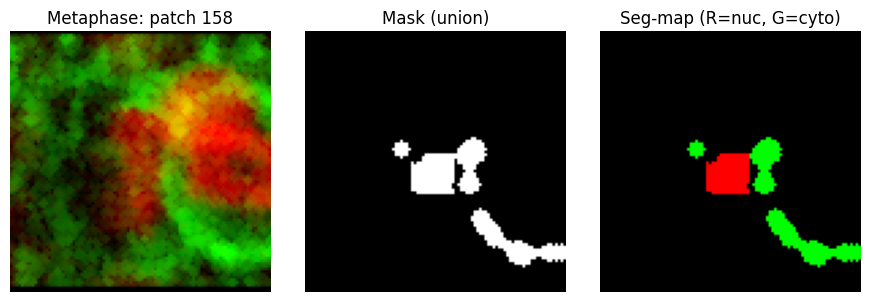

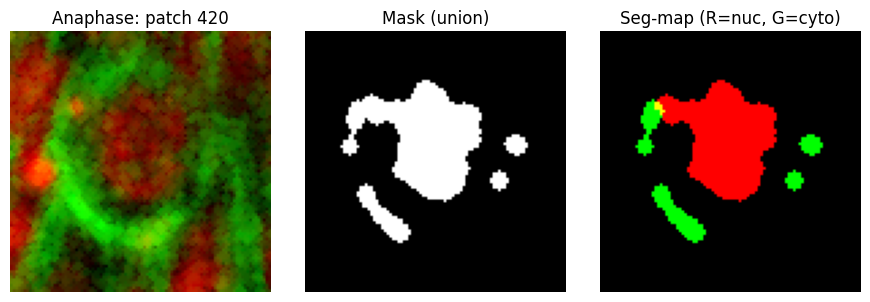

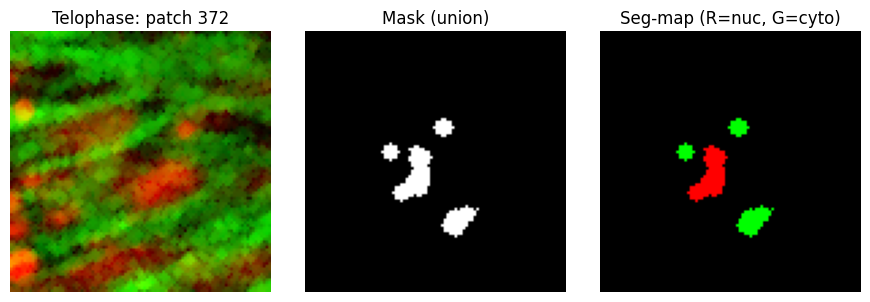

In [ ]:
# --- Cell 4A-QuickView: one random sample per class (patch, mask, seg) ---
import random
import matplotlib.pyplot as plt

random.seed(7)
for cls in CLASSES:
    ann_ids = class_to_train_ann_ids.get(cls, [])
    if not ann_ids:
        print(f"[skip] No patches for class {cls}")
        continue
    ann_id = random.choice(ann_ids)
    patch_path = ann_to_patch[ann_id]
    mask_path  = Path(MASKS_DIR) / cls / f"mask_{ann_id}.png"
    seg_path   = Path(MASKS_DIR) / cls / f"seg_{ann_id}.png"

    patch = np.asarray(Image.open(patch_path).convert("RGB"))
    mask  = np.asarray(Image.open(mask_path).convert("L"))
    seg   = np.asarray(Image.open(seg_path).convert("RGB"))

    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    axes[0].imshow(patch); axes[0].set_title(f"{cls}: patch {ann_id}")
    axes[1].imshow(mask, cmap="gray"); axes[1].set_title("Mask (union)")
    axes[2].imshow(seg); axes[2].set_title("Seg-map (R=nuc, G=cyto)")
    for ax in axes: ax.axis("off")
    plt.tight_layout()
    plt.show()


In [8]:
# Build per-class kept/dropped counts using the proposed gates
kept, dropped = defaultdict(int), defaultdict(int)
for cls, ann_id, area, snr, ecc, psep, brr in qc_rows:
    ok = (area >= AREA_MIN) and (snr >= SNR_MIN) and (brr <= BRR_MAX)
    (kept if ok else dropped)[cls] += 1
print("\nKept / Dropped per class:")
for cls in CLASSES:
    print(f"{cls:10s}: {kept[cls]} kept, {dropped[cls]} dropped")

NameError: name 'AREA_MIN' is not defined

In [9]:
# --- Cell 5: QC summary & thresholds ---
import numpy as np
from collections import defaultdict

by_cls = defaultdict(list)
for cls, ann_id, area, snr, ecc, psep, brr in qc_rows:
    by_cls[cls].append((area, snr, ecc, psep, brr))

print("\n=== QC SUMMARY (mean ± sd) ===")
for cls in CLASSES:
    vals = np.array(by_cls.get(cls, []), dtype=float)
    if vals.size == 0:
        print(f"{cls:10s} : (no data)")
        continue
    means = vals.mean(axis=0)
    sdevs = vals.std(axis=0)
    print(f"{cls:10s} : area {means[0]:.3f}±{sdevs[0]:.3f} | SNR {means[1]:.2f}±{sdevs[1]:.2f} | "
          f"ecc {means[2]:.2f}±{sdevs[2]:.2f} | psep {means[3]:.2f}±{sdevs[3]:.2f} | "
          f"border-red {means[4]:.3f}±{sdevs[4]:.3f}")

# Example gate suggestions (tweak after you inspect):
AREA_MIN   = 0.01     # drop tiny nuclei
SNR_MIN    = 2.0      # too noisy otherwise
BRR_MAX    = 0.08     # too much border red => neighbor leakage
print("\nProposed QC gates:",
      f"AREA_MIN={AREA_MIN}, SNR_MIN={SNR_MIN}, BORDER_RED_RATIO_MAX={BRR_MAX}")



=== QC SUMMARY (mean ± sd) ===
Prophase   : area 0.028±0.028 | SNR 3.42±1.07 | ecc 0.74±0.16 | psep 9.63±6.79 | border-red 0.001±0.005
Metaphase  : area 0.019±0.016 | SNR 4.10±1.22 | ecc 0.77±0.18 | psep 9.64±8.11 | border-red 0.000±0.003
Anaphase   : area 0.019±0.015 | SNR 3.05±0.94 | ecc 0.77±0.16 | psep 9.09±5.81 | border-red 0.000±0.002
Telophase  : area 0.017±0.011 | SNR 2.94±1.35 | ecc 0.74±0.21 | psep 8.52±5.84 | border-red 0.001±0.003

Proposed QC gates: AREA_MIN=0.01, SNR_MIN=2.0, BORDER_RED_RATIO_MAX=0.08


In [10]:
# --- Cell 6: Pipeline summary & manifest (run after Cell 5) ---
import os, json
from pathlib import Path
from collections import defaultdict
import numpy as np

# --- Inputs expected from earlier cells ---
# CLASSES, PROJECTION, MIP_MODE
# PATCH_CACHE_TRAIN, MASKS_DIR
# ann_to_patch (dict ann_id -> patch_path)
# class_to_train_ann_ids (dict class -> [ann_ids])
# qc_rows: list of tuples (cls, ann_id, area, snr, ecc, psep, brr)
# AREA_MIN, SNR_MIN, BRR_MAX  (QC gates from Cell 5)

print("\n=== PIPELINE SUMMARY (after Cell 5) ===")
print(f"Projection: {PROJECTION} | MIP_MODE: {MIP_MODE}")
print(f"Patch cache dir: {os.path.abspath(PATCH_CACHE_TRAIN)}")
print(f"Masks dir     : {os.path.abspath(MASKS_DIR)}")

# 1) Cached patches count (from cache folders or bookkeeping)
cached_counts = {c: len(class_to_train_ann_ids.get(c, [])) for c in CLASSES}
print("\n-- Cached train patches (counts) --")
for c in CLASSES:
    print(f"{c:10s}: {cached_counts.get(c, 0)}")
print(f"TOTAL cached : {sum(cached_counts.values())}")

# 2) Masks actually written on disk
mask_counts = {}
seg_counts  = {}
for c in CLASSES:
    mdir = Path(MASKS_DIR) / c
    mask_counts[c] = len(list(mdir.glob("mask_*.png"))) if mdir.exists() else 0
    seg_counts[c]  = len(list(mdir.glob("seg_*.png")))  if mdir.exists() else 0
print("\n-- Processed masks written --")
for c in CLASSES:
    print(f"{c:10s}: masks={mask_counts[c]:4d} | segs={seg_counts[c]:4d}")
print(f"TOTAL masks  : {sum(mask_counts.values())}")

# 3) QC totals & empties
total_qc = len(qc_rows)
empty_masks = sum(1 for _,_,area,_,_,_,_ in qc_rows if float(area) <= 0.0)
print("\n-- QC rows --")
print(f"QC rows total: {total_qc}")
print(f"Empty nucleus masks: {empty_masks} ({100.0*empty_masks/max(1,total_qc):.1f}%)")

# 4) Kept vs dropped by class using current gates
kept, dropped = defaultdict(list), defaultdict(list)
for cls, ann_id, area, snr, ecc, psep, brr in qc_rows:
    ok = (float(area) >= float(AREA_MIN)) and (float(snr) >= float(SNR_MIN)) and (float(brr) <= float(BRR_MAX))
    (kept if ok else dropped)[cls].append((ann_id, area, snr, ecc, psep, brr))

print("\n-- Kept / Dropped by class (using gates) --")
tot_kept = tot_drop = 0
for c in CLASSES:
    k = len(kept.get(c, []))
    d = len(dropped.get(c, []))
    tot_kept += k; tot_drop += d
    print(f"{c:10s}: kept={k:4d} | dropped={d:4d}")
print(f"TOTAL kept   : {tot_kept}")
print(f"TOTAL dropped: {tot_drop}")

# 5) Write manifest (for next stage)
#    Each row carries: class, ann_id, patch_path, mask_path, seg_path, QC metrics, projection, MIP flag
manifest = []
for c in CLASSES:
    for (ann_id, area, snr, ecc, psep, brr) in kept.get(c, []):
        patch_path = ann_to_patch.get(ann_id, "")
        mask_path  = str(Path(MASKS_DIR) / c / f"mask_{ann_id}.png")
        seg_path   = str(Path(MASKS_DIR) / c / f"seg_{ann_id}.png")
        manifest.append({
            "class": c,
            "ann_id": int(ann_id),
            "patch_path": patch_path,
            "mask_path": mask_path,
            "seg_path": seg_path,
            "area": float(area),
            "snr": float(snr),
            "ecc": float(ecc),
            "peak_sep": float(psep),
            "border_red": float(brr),
            "projection": PROJECTION,
            "mip_mode": bool(MIP_MODE),
        })

MANIFEST_JSON = "kept_manifest.json"
MANIFEST_CSV  = "kept_manifest.csv"

# Save JSON
with open(MANIFEST_JSON, "w") as f:
    json.dump(manifest, f, indent=2)

# Save CSV
import csv
if manifest:
    keys = list(manifest[0].keys())
    with open(MANIFEST_CSV, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=keys)
        w.writeheader()
        w.writerows(manifest)

print("\n-- Outputs for next stage --")
print(f"Manifest JSON: {os.path.abspath(MANIFEST_JSON)}")
print(f"Manifest CSV : {os.path.abspath(MANIFEST_CSV)}")

# 6) Quick red flags (to help adjust gates)
def _mean_std(vals): 
    arr = np.array(vals, dtype=float)
    return (arr.mean(), arr.std()) if arr.size else (0.0, 0.0)

print("\n-- Quick red flags / hints --")
# High border-red classes
brr_by_c = {c: [brr for (_,_,_,_,_,brr) in kept.get(c, [])] for c in CLASSES}
for c, vals in brr_by_c.items():
    mean_brr, sd_brr = _mean_std(vals)
    if mean_brr > 0.06:  # heuristic
        print(f"Note: {c} shows mean border-red ~{mean_brr:.3f} (consider tightening bbox pad or watershed).")
# Low SNR classes
snr_by_c = {c: [snr for (_,_,snr,_,_,_) in kept.get(c, [])] for c in CLASSES}
for c, vals in snr_by_c.items():
    mean_snr, sd_snr = _mean_std(vals)
    if mean_snr < (2.3 if MIP_MODE else 2.0):
        print(f"Note: {c} mean SNR ~{mean_snr:.2f}; check flat-field/threshold or relax SNR gate slightly for this class.")



=== PIPELINE SUMMARY (after Cell 5) ===
Projection: max_projection | MIP_MODE: True
Patch cache dir: /home/sebas_dev_linux/projects/snn_project/Diffusion_SNN_ML_v0/patch_cache_train
Masks dir     : /home/sebas_dev_linux/projects/snn_project/Diffusion_SNN_ML_v0/processed_masks_train

-- Cached train patches (counts) --
Prophase  : 282
Metaphase : 146
Anaphase  : 69
Telophase : 59
TOTAL cached : 556

-- Processed masks written --
Prophase  : masks= 282 | segs= 282
Metaphase : masks= 146 | segs= 146
Anaphase  : masks=  69 | segs=  69
Telophase : masks=  59 | segs=  59
TOTAL masks  : 556

-- QC rows --
QC rows total: 556
Empty nucleus masks: 1 (0.2%)

-- Kept / Dropped by class (using gates) --
Prophase  : kept= 189 | dropped=  93
Metaphase : kept=  92 | dropped=  54
Anaphase  : kept=  43 | dropped=  26
Telophase : kept=  33 | dropped=  26
TOTAL kept   : 357
TOTAL dropped: 199

-- Outputs for next stage --
Manifest JSON: /home/sebas_dev_linux/projects/snn_project/Diffusion_SNN_ML_v0/kept_

# Diffusion process

In [ ]:
# Cell 6
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-seg", torch_dtype=dtype)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=dtype,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_attention_slicing()   # VRAM saver (use this instead of xFormers)
pipe.enable_vae_slicing()
pipe.to(device)


/home/sebas_dev_linux/miniconda3/envs/diff/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/2

StableDiffusionControlNetPipeline {
  "_class_name": "StableDiffusionControlNetPipeline",
  "_diffusers_version": "0.35.2",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "controlnet": [
    "diffusers",
    "ControlNetModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "UniPCMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
# Cell 5 — Diffusion scaffolding (ControlNet Seg) OR MOCK texture generator
MODE = "DIFFUSION" #"MOCK"   # change to "DIFFUSION" to enable Stable Diffusion + ControlNet(seg)

PROMPTS = {
    "Prophase":  "fluorescence microscopy, nucleus in prophase, confocal, cellular texture",
    "Metaphase": "fluorescence microscopy, metaphase, chromosomes aligned at the equatorial plate",
    "Anaphase":  "fluorescence microscopy, anaphase, chromosomes to opposite poles",
    "Telophase": "fluorescence microscopy, telophase, two daughter nuclei forming",
}
NEGATIVE = "cartoon, text, watermark, artifacts, blurry, out of focus"

pipe = None
device = None

def try_load_diffusion():
    try:
        from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
        import torch
    except Exception as e:
        print("Diffusers not available; remaining in MOCK mode.\\n", e)
        return None, None
    device = "cuda" if torch.cuda.is_available() else "cpu"
    controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-seg")
    pipe = StableDiffusionControlNetPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        controlnet=controlnet,
        safety_checker=None,
    )
    pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
    pipe = pipe.to(device)
    print(f"Loaded SD1.5 + ControlNet(seg) on {device}")
    return pipe, device

def generate_with_controlnet(pipe, device, rgb_img: Image.Image, seg_mask: Image.Image, prompt: str,
                             strength=0.55, guidance_scale=6.5, steps=24, seed=None):
    import torch
    if seed is None:
        seed = random.randint(0, 1_000_000)
    g = torch.Generator(device=device).manual_seed(seed)
    rgb512 = rgb_img.resize((512,512), Image.Resampling.BICUBIC)
    seg512 = seg_mask.resize((512,512), Image.Resampling.NEAREST).convert('RGB')
    out = pipe(
        prompt=prompt, image=rgb512, control_image=seg512,
        negative_prompt=NEGATIVE, generator=g,
        num_inference_steps=steps, guidance_scale=guidance_scale, strength=strength,
    )
    im = out.images[0].resize((IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS)
    return im, {"seed": seed, "steps": steps, "guidance_scale": guidance_scale, "strength": strength}

# MOCK generator — no internet/GPU required
import numpy as np
def mock_generate_from_mask(mask_img: Image.Image, seed=None) -> Image.Image:
    r = random.Random(seed or random.randint(0, 999_999))
    m = mask_img if mask_img.mode == "L" else mask_img.convert("L")
    base = Image.new("RGB", m.size, (r.randint(0,25),)*3)
    # noise texture
    tex = Image.effect_noise(m.size, r.randint(30,90)).convert("L")
    tex = tex.filter(ImageFilter.GaussianBlur(radius=r.uniform(0.8, 1.6)))
    color = Image.new("RGB", m.size, (r.randint(80,240), r.randint(80,240), r.randint(80,240)))
    color = Image.blend(color, Image.new("RGB", m.size, (r.randint(0,40),)*3), r.uniform(0.2, 0.5))
    arr_c = np.array(color).astype(np.int16)
    arr_t = np.array(tex).astype(np.float32) / 255.0
    arr_c = np.clip(arr_c * (0.7 + 0.6*arr_t[...,None]), 0, 255).astype(np.uint8)
    tex_color = Image.fromarray(arr_c, mode="RGB")
    m_blur = m.filter(ImageFilter.GaussianBlur(radius=0.8))
    out = Image.composite(tex_color, base, m_blur)
    # gentle halo
    edge = m.filter(ImageFilter.FIND_EDGES).filter(ImageFilter.GaussianBlur(radius=0.7))
    edge_alpha = ImageOps.autocontrast(edge).point(lambda x: int(x*0.15))
    overlay_rgba = Image.new("RGBA", m.size, (255,255,255,0)); overlay_rgba.putalpha(edge_alpha)
    out_rgba = out.convert("RGBA")
    final = Image.alpha_composite(out_rgba, overlay_rgba).convert("RGB")
    return final

if MODE.upper().startswith("DIFF"):
    pipe, device = try_load_diffusion()
else:
    print("MODE=MOCK — using texture-based generator for quick wiring test.")

In [ ]:
# Cell 6 — Synthesize per class (train-only), with target counts and manifest
from collections import Counter
from pathlib import Path
import json

# Choose a per-class target: bring all classes up to the max train count
train_counts = {cls: len(class_to_train_ann_ids[cls]) for cls in CLASSES}
target = max(train_counts.values())
print("Train counts:", train_counts, "=> target per class:", target)

manifest = []
for cls in CLASSES:
    outd = Path(SYNTH_DIR)/cls
    outd.mkdir(parents=True, exist_ok=True)

# Iterate ann_ids, generate as many as needed to reach target
for cls, ann_ids in class_to_train_ann_ids.items():
    need = max(0, target - len(ann_ids))
    if need == 0:
        print(f"{cls}: already at target, skipping generation.")
        continue
    print(f"{cls}: generating {need} images…")
    # round-robin over existing train patches
    k = 0
    while k < need:
        for ann_id in ann_ids:
            if k >= need: break
            src_patch = ann_to_patch[ann_id]
            mask_path = Path(MASKS_DIR)/cls/f"mask_{ann_id}.png"
            if not Path(src_patch).exists() or not mask_path.exists():
                continue
            rgb = Image.open(src_patch).convert('RGB').resize((IMG_SIZE, IMG_SIZE), Image.Resampling.BICUBIC)
            msk = Image.open(mask_path).convert('L').resize((IMG_SIZE, IMG_SIZE), Image.Resampling.NEAREST)
            if MODE.upper().startswith("DIFF") and pipe is not None:
                out_img, meta = generate_with_controlnet(pipe, device, rgb, msk, PROMPTS[cls])
                method = "controlnet_seg"
                seed = meta["seed"]
            else:
                seed = 10_000 + k
                out_img = mock_generate_from_mask(msk, seed=seed)
                method = "mock_from_mask"
            out_name = f"{cls.lower()}_synth_{ann_id}_{k:04d}.png"
            out_path = Path(SYNTH_DIR)/cls/out_name
            out_img.save(out_path)
            manifest.append({
                "class": cls,
                "file": str(out_path),
                "source_patch": src_patch,
                "source_mask": str(mask_path),
                "method": method,
                "seed": seed,
                "img_size": IMG_SIZE,
            })
            k += 1

# Save manifest
man_path = Path(ARTIFACTS)/"synth_manifest.json"
with open(man_path, "w") as f:
    json.dump(manifest, f, indent=2)
print("Wrote manifest:", man_path, "| total synth:", len(manifest))

In [ ]:
# Cell 7 — Light de-dup (aHash) and class counts report
import numpy as np

def average_hash(img: Image.Image, hash_size=8):
    g = ImageOps.grayscale(img).resize((hash_size, hash_size), Image.Resampling.LANCZOS)
    arr = np.array(g).astype(np.float32)
    th = arr.mean()
    bits = (arr > th).astype(np.uint8).flatten()
    h = 0
    for b in bits:
        h = (h << 1) | int(b)
    return h

def hamming(a, b):
    return bin(a ^ b).count("1")

removed = 0
for cls in CLASSES:
    files = sorted((Path(SYNTH_DIR)/cls).glob("*.png"))
    seen = []
    for fp in files:
        img = Image.open(fp)
        ah = average_hash(img)
        if any(hamming(ah, s) <= 2 for s in seen):
            fp.unlink(missing_ok=True)
            removed += 1
        else:
            seen.append(ah)
print("Removed near-duplicates:", removed)

counts = {cls: len(list((Path(SYNTH_DIR)/cls).glob('*.png'))) for cls in CLASSES}
print("Synthetic counts (after dedup):", counts)

In [ ]:
# Cell 8 — Preview grid (first few per class)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(CLASSES), 4, figsize=(6, 6))
for r, cls in enumerate(CLASSES):
    files = sorted(glob.glob(str((Path(SYNTH_DIR) / cls / '*.png').resolve())))[:4]
    for c, f in enumerate(files):
        ax = axes[r, c]
        ax.imshow(Image.open(f))
        ax.set_title(f"{cls} synth", fontsize=8)
        ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Cell 9 — Zip for portability
import zipfile, os
zip_path = Path(ARTIFACTS) / "synthetic_patches.zip"
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for cls in CLASSES:
        for f in (Path(SYNTH_DIR)/cls).glob("*.png"):
            zf.write(f, arcname=f"synthetic_patches/{cls}/{f.name}")
    zf.write(Path(ARTIFACTS)/"synth_manifest.json", arcname="artifacts/synth_manifest.json")
print("Zipped:", zip_path)